In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from numba import njit
import sys
sys.path.append('../../../polaritymodel')
from polaritymodel import pdeRK, interactive_fig
%matplotlib notebook

### Parameters

In [3]:
D = 0.1
dos = 1
kon = 0.1
koff = 0.01
psi = 0.1
kAnt = 0.1
xsteps = 100
eAnt = 2

### PDE

In [16]:
def dxdt_ode(X, kAP=kAnt, kPA=kAnt, kon=kon, koff=koff, psi=psi, eAnt=eAnt, 
             pA=dos, pP=dos):
        
    Am = X[0]
    Pm = X[1] 
    Ac = pA - psi * Am
    Pc = pP - psi * Pm
    
    r = np.zeros(6)
    r[0] = kon * Ac  
    r[1] = koff * Am
    r[2] = kon * Pc  
    r[3] = koff * Pm
    
    r[4] = kAP * (Pm ** eAnt) * Am
    r[5] = kPA * (Am ** eAnt) * Pm
    
    dAm = r[0] - r[1] - r[4]
    dPm = r[2] - r[3] - r[5]    
    return dAm, dPm

def diffusion(concs, dx=1):
    d = concs[:-2] - 2 * concs[1:-1] + concs[2:]
    return d / (dx ** 2)


def dxdt_pde(X, Da=D, Dp=D, kAP=kAnt, kPA=kAnt, kon=kon, koff=koff, 
         psi=psi, eAnt=eAnt, pA=dos, pP=dos, xsteps=xsteps, deltax=0.5, cue=False, cue_strength=1):
    
    # Species
    Am = X[0]
    Pm = X[1]
    Ac = pA - psi * np.mean(Am)
    Pc = pP - psi * np.mean(Pm)

    # Reaction matrices
    rp = np.zeros((4, xsteps))
    ra = np.zeros((4, xsteps))

    # A reactions
    ra[0] = kon * Ac  
    ra[1] = koff * Am
    ra[2] = kAP * (Pm ** eAnt) * Am
    ra[3, 1:-1] = Da * diffusion(Am, deltax)
    ra[3, 0], ra[3, -1] = ra[3, 1], ra[3, -2]
    
    # P reactions
    rp[0] = kon * Pc  
    rp[1] = koff * Pm
    rp[2] = kPA * (Am ** eAnt) * Pm
    rp[3, 1:-1] = Dp * diffusion(Pm, deltax)
    rp[3, 0], rp[3, -1] = rp[3, 1], rp[3, -2]
    
    # Cue
    if cue:
        rp[2, 90:] /= cue_strength

    # PDEs
    dAm = ra[0] - ra[1] - ra[2] + ra[3]
    dPm = rp[0] - rp[1] - rp[2] + rp[3]
    
    return dAm, dPm

### Initial conditions

In [17]:
def ode_func(X, t):
    return dxdt_ode(X, kAP=0, kPA=0)

soln = odeint(ode_func, (0, 0), t=np.linspace(0, 10000, 100000))[-1]
A0 = soln[0] * 2 * np.r_[np.ones([xsteps // 2]), np.zeros([xsteps // 2])]
P0 = soln[1] * 2 * np.r_[np.zeros([xsteps // 2]), np.ones([xsteps // 2])]
X0a = [A0, P0]

### Initial conditions - v2

In [18]:
def ode_func_v2(X, t):
    return dxdt_ode(X, kAP=kAnt, kPA=kAnt)

soln = odeint(ode_func_v2, (dos / psi, 0), t=np.linspace(0, 10000, 100000))[-1]
A0 = soln[0] * np.linspace(1.01, 0.99, xsteps)
P0 = soln[1] * np.linspace(0.99, 1.01, xsteps)
X0b = [A0, P0]

### Test simulation - no cue

CPU times: user 503 ms, sys: 10.5 ms, total: 514 ms
Wall time: 508 ms


<IPython.core.display.Javascript object>


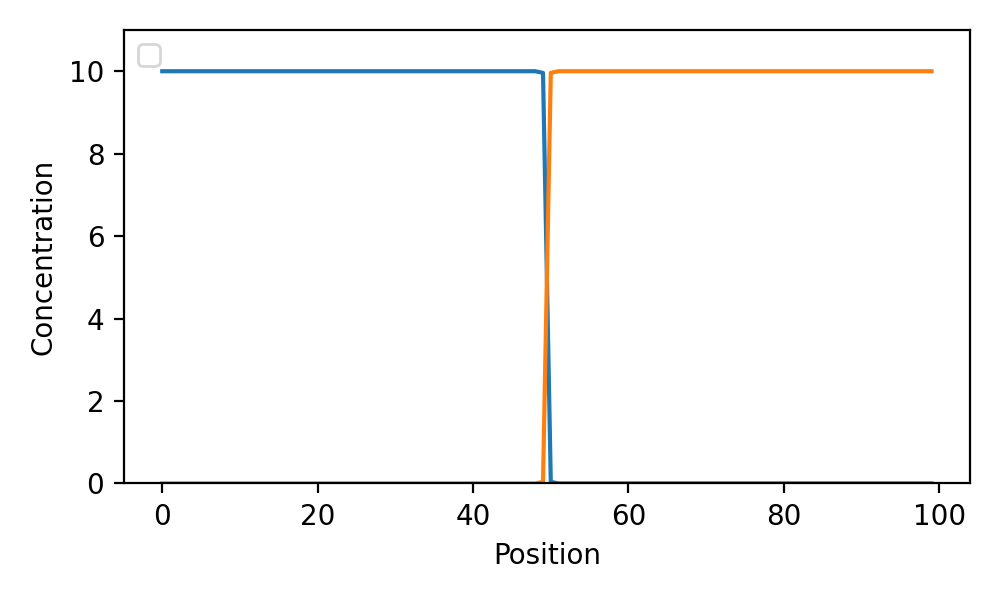

interactive(children=(FloatSlider(value=0.0, description='time', max=100.08529434751765, step=1.0), Output()),…

In [20]:
def pde_func(X):
    return dxdt_pde(np.array(X))

%time soln, time, solns, times = pdeRK(dxdt=pde_func, X0=X0a, Tmax=100, deltat=0.01, t_eval=np.arange(0, 1001, 1))
interactive_fig(solns, times)

### Test simulation - transient cue

<IPython.core.display.Javascript object>


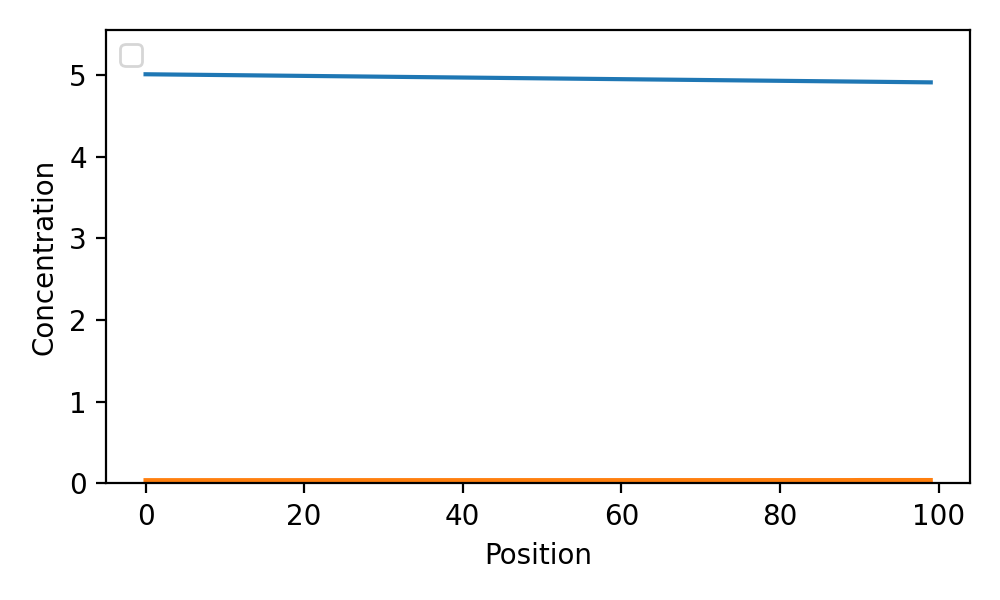

interactive(children=(FloatSlider(value=0.0, description='time', max=1000.1434848301324, step=1.0), Output()),…

In [21]:
def pde_func1(X):
    return dxdt_pde(np.array(X), cue=True, cue_strength=3.5)

def pde_func2(X):
    return dxdt_pde(np.array(X))


soln, _, solns1, times1 = pdeRK(dxdt=pde_func1, X0=X0b, Tmax=500, deltat=0.01, t_eval=np.arange(0, 1001, 1))
_, _, solns2, times2 = pdeRK(dxdt=pde_func2, X0=soln, Tmax=500, deltat=0.01, t_eval=np.arange(0, 1001, 1))

interactive_fig([np.r_[x, y] for x, y in zip(solns1, solns2)], np.r_[times1, times2 + times1[-1]])

Notes:
- 10 > SB
- 7 > SB
- 6 > SB
- 4 > SB
- 3.75 SB
- 3.5 > no SB
- 3 > no SB
- 2 > no SB

### Simulations for figs

In [22]:
def pde_func1(X):
    return dxdt_pde(np.array(X), cue=True, cue_strength=3)

def pde_func2(X):
    return dxdt_pde(np.array(X))

soln, _, solns_sub_pre, times_sub_pre = pdeRK(dxdt=pde_func1, X0=X0b, Tmax=1000, deltat=0.01, 
                                              t_eval=np.arange(0, 1001, 10))
_, _, solns_sub_post, times_sub_post = pdeRK(dxdt=pde_func2, X0=soln, Tmax=1000, deltat=0.01, 
                                           t_eval=np.arange(0, 1001, 10))

In [23]:
def pde_func1(X):
    return dxdt_pde(np.array(X), cue=True, cue_strength=3.5)

def pde_func2(X):
    return dxdt_pde(np.array(X))

soln, _, solns_sup_pre, times_sup_pre = pdeRK(dxdt=pde_func1, X0=X0b, Tmax=1000, deltat=0.01, 
                                              t_eval=np.arange(0, 1001, 10))
_, _, solns_sup_post, times_sup_post = pdeRK(dxdt=pde_func2, X0=soln, Tmax=1000, deltat=0.01, 
                                           t_eval=np.arange(0, 1001, 10))

### Figs

In [24]:
def func(solns, times, fig_times, alphas, ymax=9, name=None):
    fig, ax = plt.subplots()
    for t, a in zip(fig_times, alphas):
        tpoint = np.argmin(abs(times - t))
        for soln, c in zip(solns, ['tab:red', 'dodgerblue']):
            ax.plot(soln[tpoint], c=c, alpha=a)
    ax.set_xlabel('Position')
    ax.set_ylabel('Concentration')
    ax.set_ylim(top=ymax)
    ax.tick_params(axis='both', labelsize=8)        
    fig.set_size_inches(2.5, 2.5)
    fig.tight_layout()
    fig.savefig('Figs/' + name + '.png', dpi=600, transparent=True)

<IPython.core.display.Javascript object>


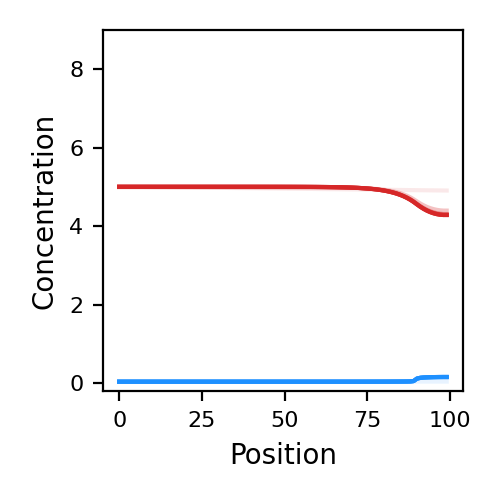

In [25]:
fig_times = [0, 200, 400, 600, 800, 1000]
alphas = np.linspace(0.1, 1, len(fig_times))
func(solns_sub_pre, times_sub_pre, fig_times, alphas, name='below_threshold_sb')

<IPython.core.display.Javascript object>


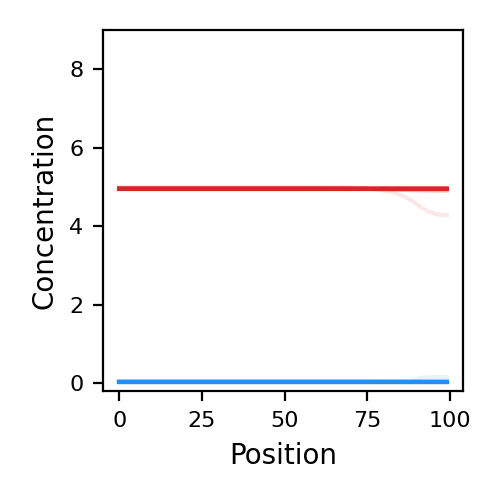

In [26]:
fig_times = [0, 200, 400, 600, 800, 1000]
alphas = np.linspace(0.1, 1, len(fig_times))
func(solns_sub_post, times_sub_post, fig_times, alphas, name='below_threshold_mp')

<IPython.core.display.Javascript object>


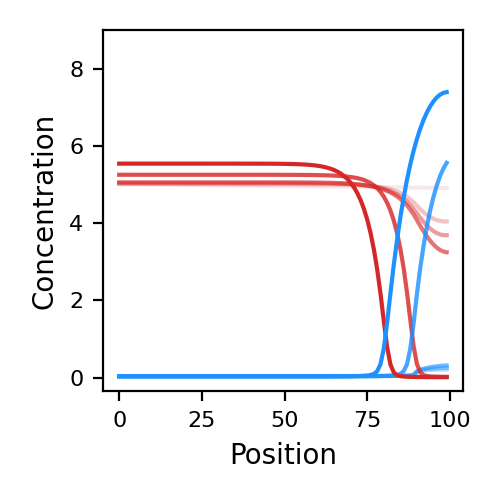

In [27]:
fig_times = [0, 200, 400, 600, 800, 1000]
alphas = np.linspace(0.1, 1, len(fig_times))
func(solns_sup_pre, times_sup_pre, fig_times, alphas, name='above_threshold_sb')

<IPython.core.display.Javascript object>


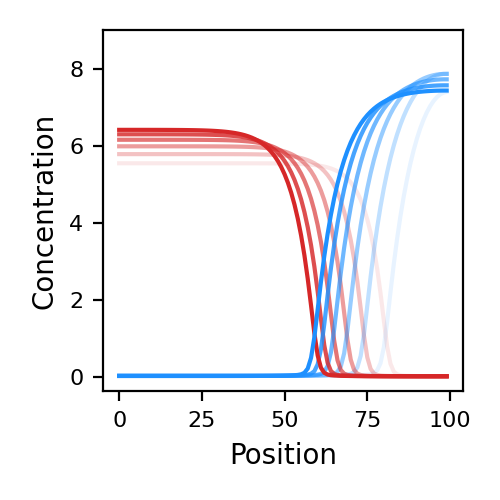

In [28]:
fig_times = [0, 200, 400, 600, 800, 1000]
alphas = np.linspace(0.1, 1, len(fig_times))
func(solns_sup_post, times_sup_post, fig_times, alphas, name='above_threshold_mp')